In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import sweetviz as sw

<h1> Задача: Побудова моделі прогнозування <u>щоденної</u> кількості броньованих автомобілів <u>без скасування</u> на період <u>січень 2019 року – лютий 2019 року</u></h1>

#### Колонки(змінні), які залишили в результаті аналізу: [Variable analysis](http://nbviewer.org/github/pruhlo/Reservation_test/blob/master/again%20VARIABLES.ipynb)

In [2]:
col = ['booking_status', 'request_date_time',
       'namber_of_passengers', 'number_of_children', 'flight_number',
       'pickup_date_time', 'return_date_time', 'company_car_class_code',
       'detail_car_class_code', 'detail_car_class_name', 'campaign',
       'basic_price', 'options_total_fee', 'coupon', 'point', 'total_amount',
       'cancel_fee', 'options']

In [3]:
data = pd.read_csv('rakuten_shinchitose.csv', encoding= 'cp932')

In [4]:
description_table = pd.read_csv('columns_description.csv', encoding= 'cp932')

In [5]:
dictionary = dict(zip(description_table['Row(JP)'], description_table['Row(EN)']))
for JP in data.columns.to_list():
    data = data.rename(columns = {JP:dictionary[JP]})

In [6]:
df = data[col]

In [7]:
df.shape

(3983, 18)

# Задамо залежну змінну

In [8]:
status_of_booking = {"キャンセル確認済":'confirmed cancellation',
                     "キャンセル済（管理画面より）":'cancelled by admin',
                     "キャンセル済（予約直後）":'cancelled right after booking',
                     "キャンセル未確認":'unconfirmed cancellation',
                     "予約確認済":'confirmed booking',
                     "予約確認済（料金変更あり）":'confirmed booking with price changes',
                     "予約未確認":'unconfirmed booking'}

df['booking_status'] = df.booking_status.apply(lambda string: status_of_booking[string])

In [9]:
def booking_status_transform(string):
    if string in ['confirmed booking', 'confirmed booking with price changes']:
        return 1
    else:
        return 0
df.booking_status = df.booking_status.apply(booking_status_transform)

In [10]:
X = df.drop('booking_status', axis=1) 
y = df['booking_status']

#### сформуємо тестову та дослідну вибіркову сукупність та подивимось на їх співвідношення

In [11]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

comparison_report = sw.compare([X_train, 'Train'], [X_test, 'Test']) 
# Displaying the analyzed data in your browser 
# comparison_report.show_html('output.html', open_browser=True)

                                             |          | [  0%]   00:00 -> (? left)


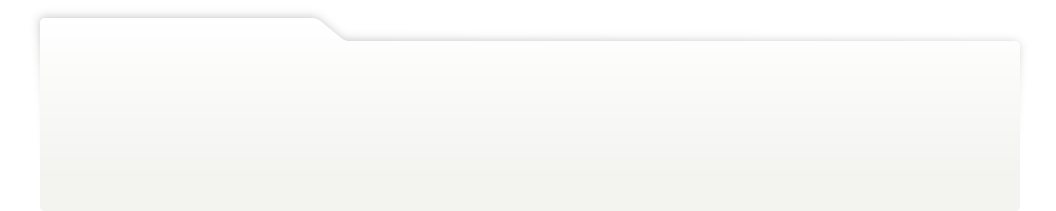
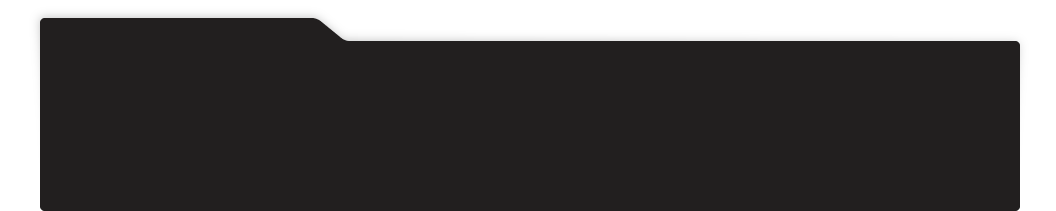
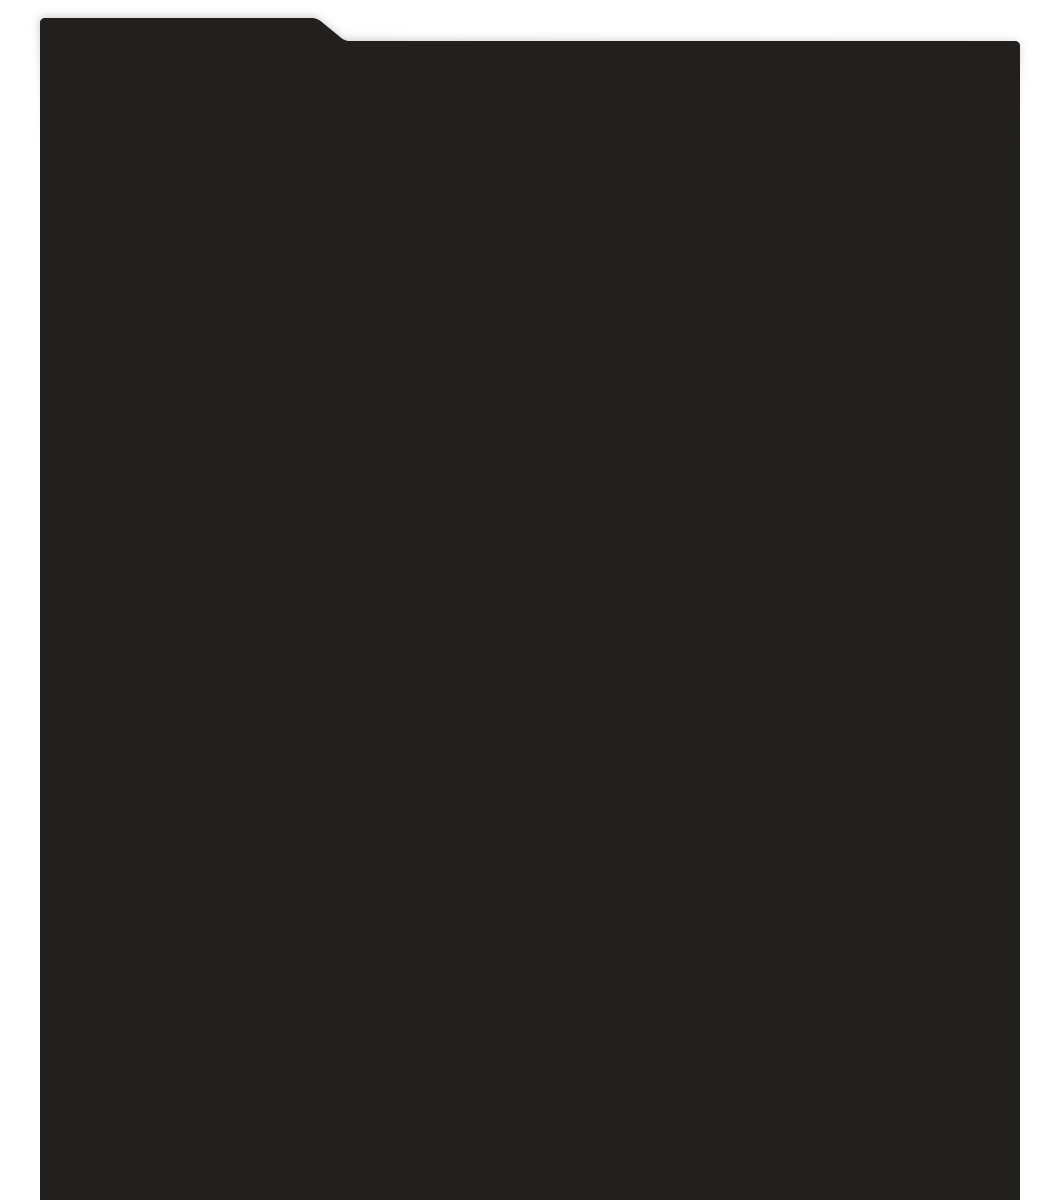
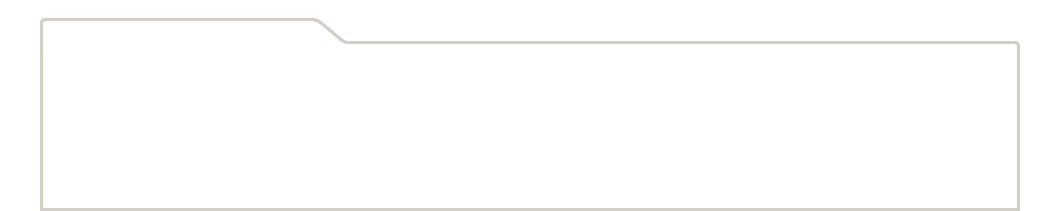
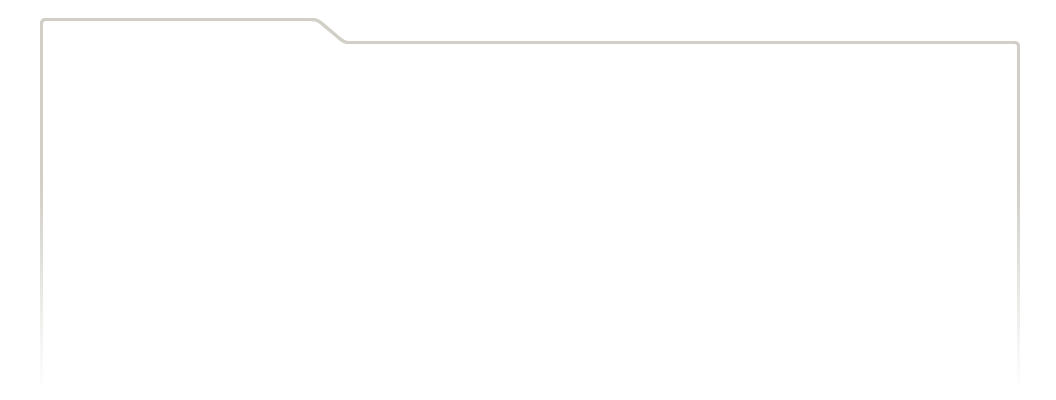
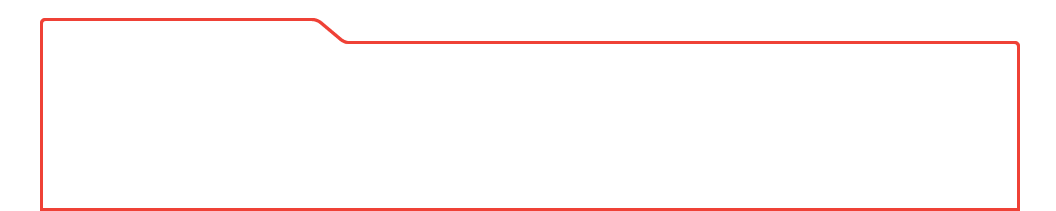
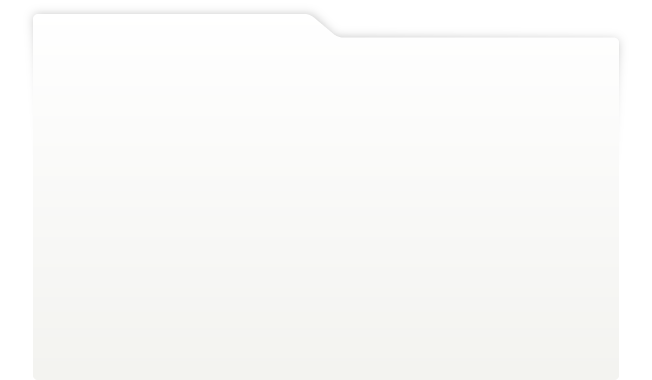
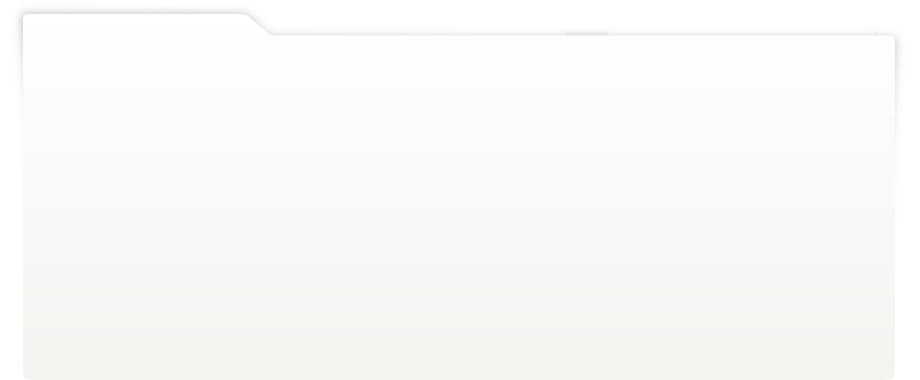
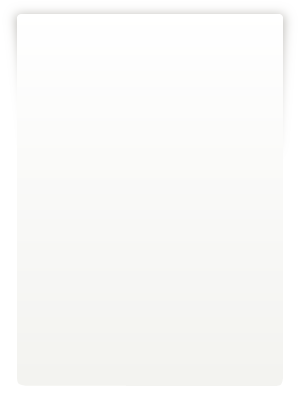
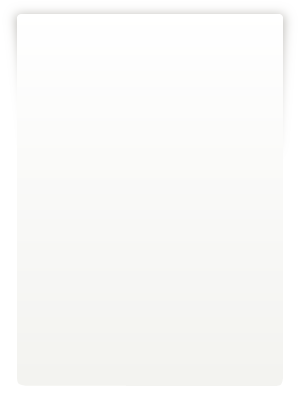
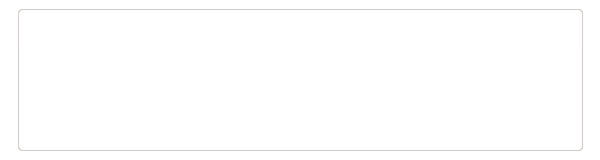
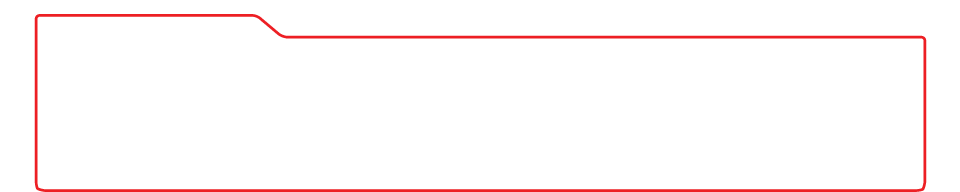
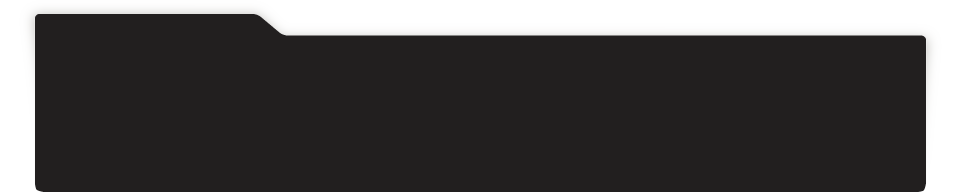
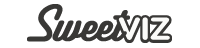
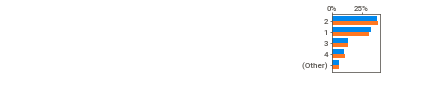
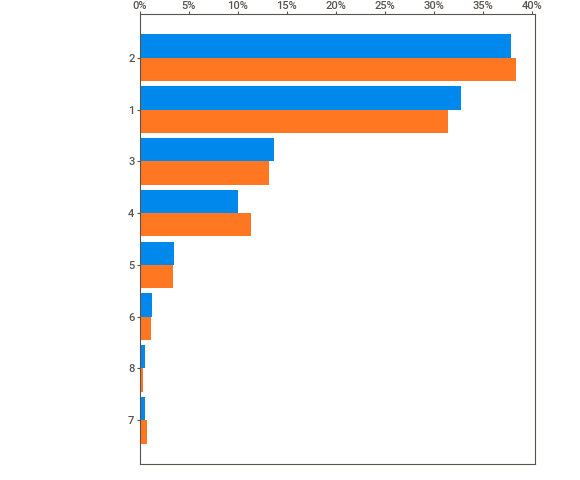
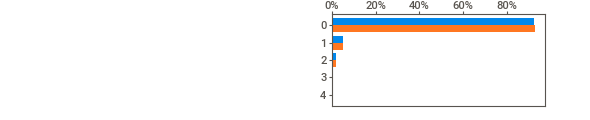
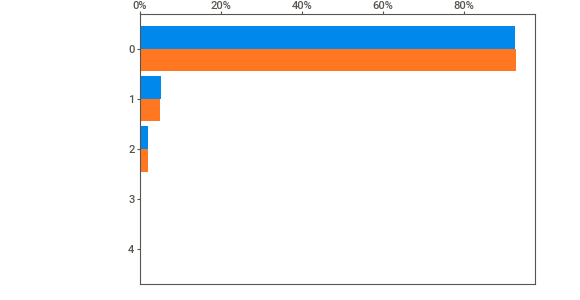
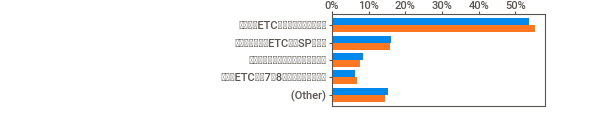
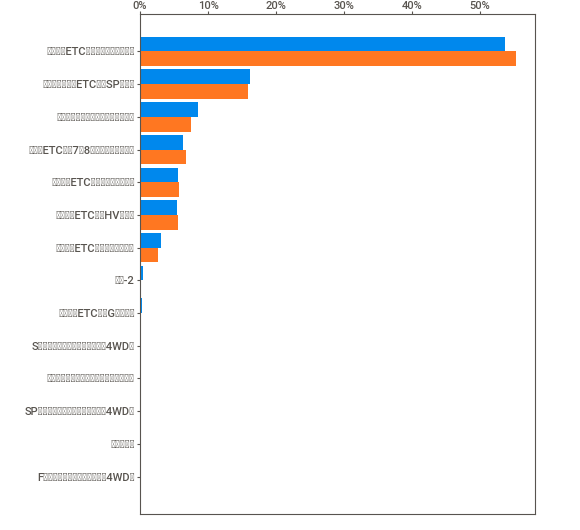
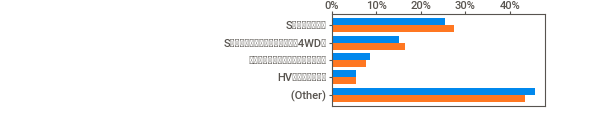
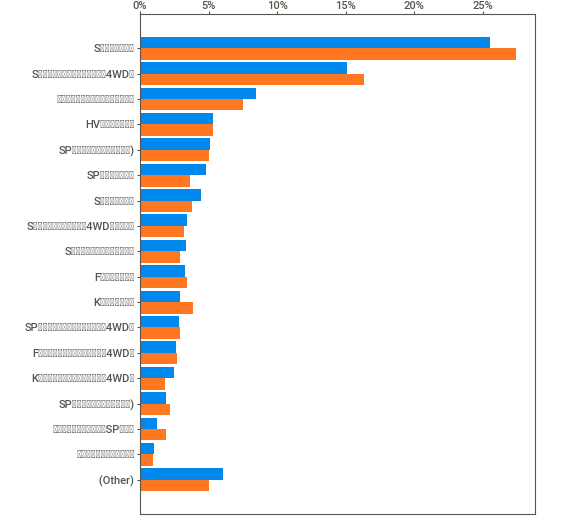
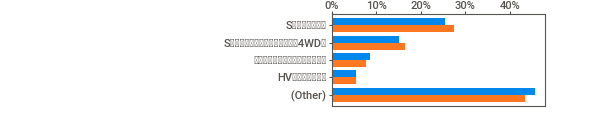
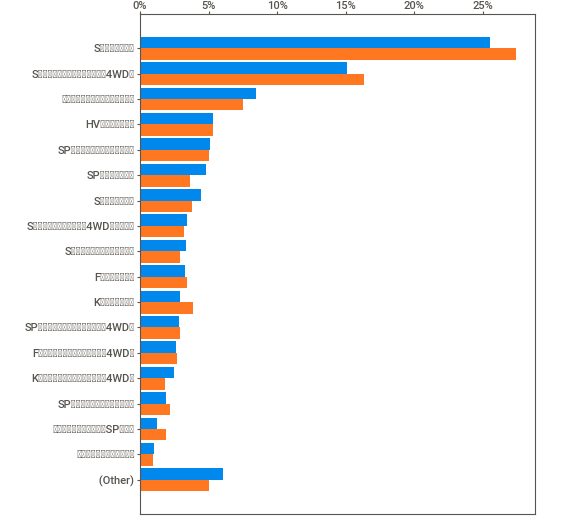
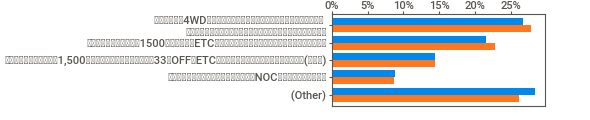
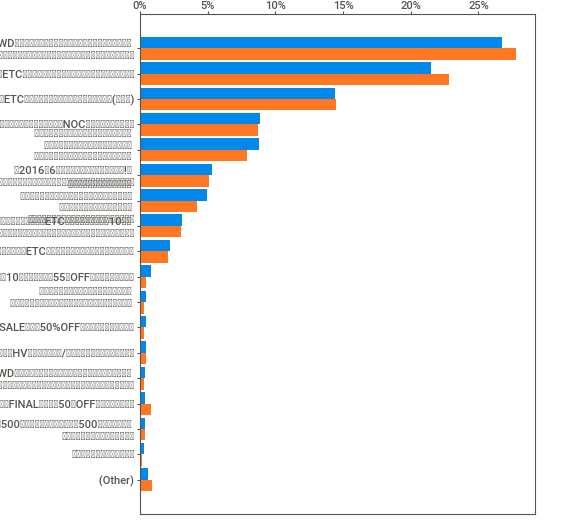
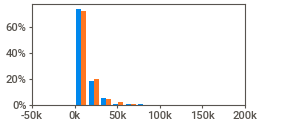
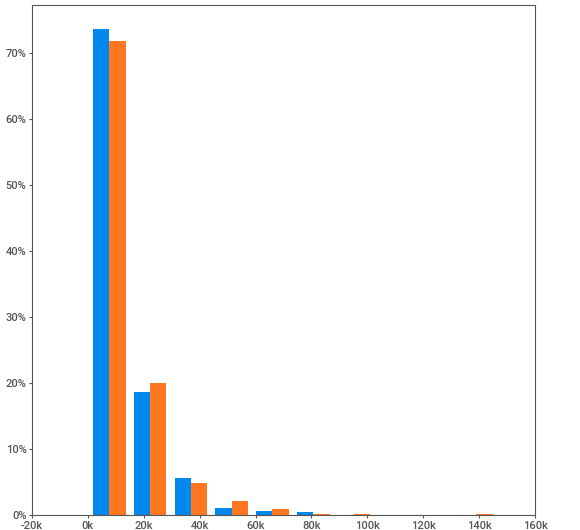
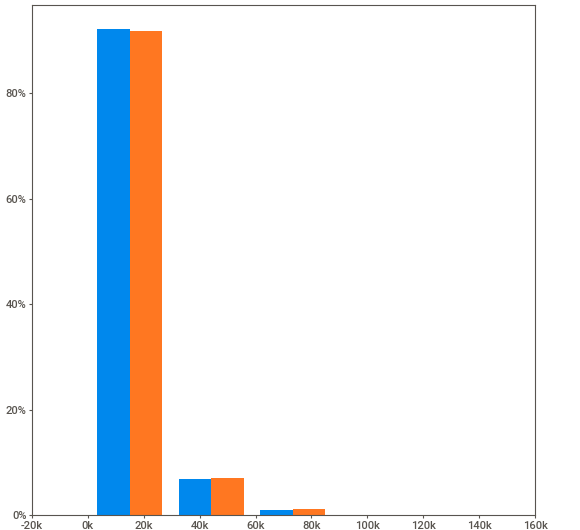
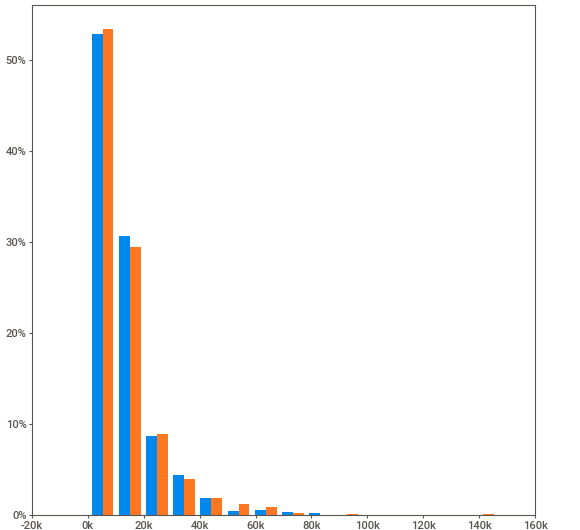
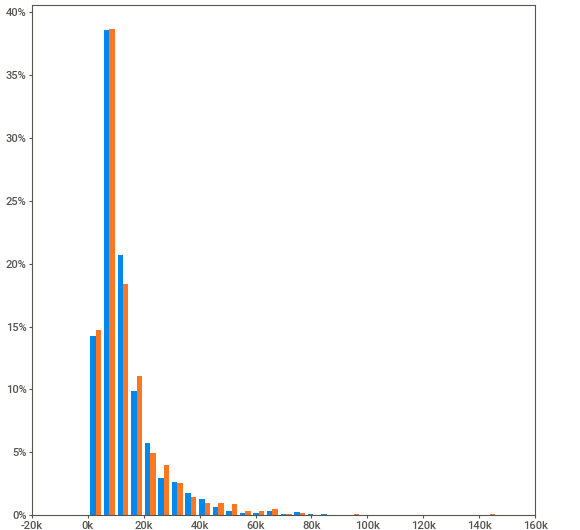
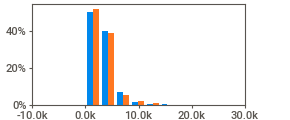
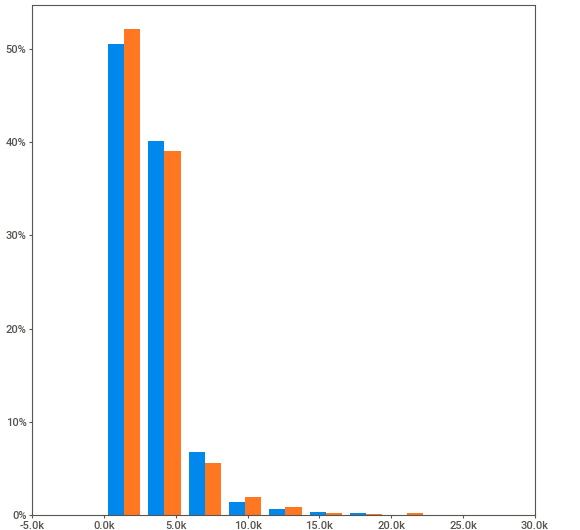
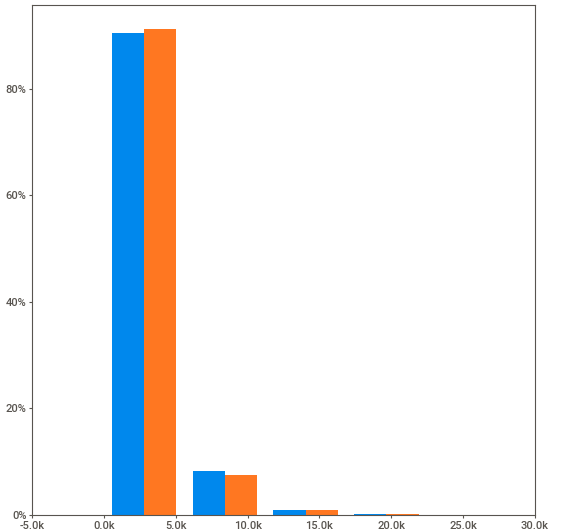
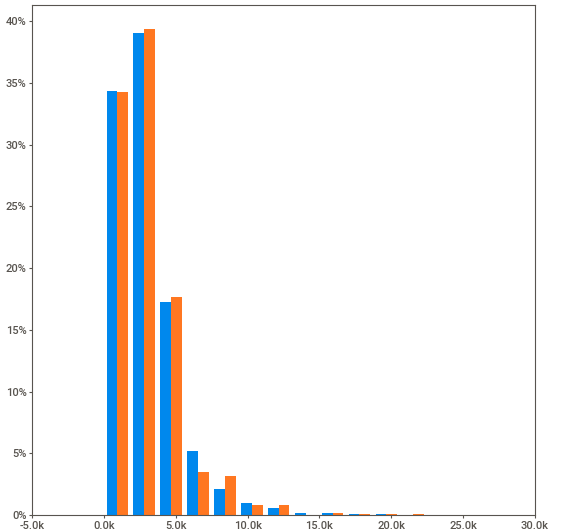
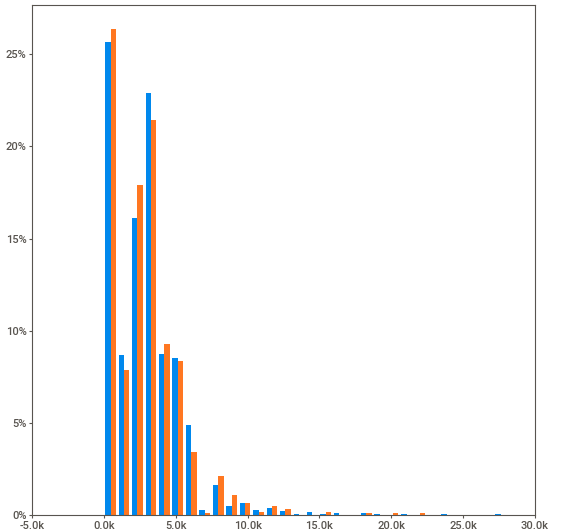
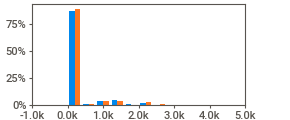
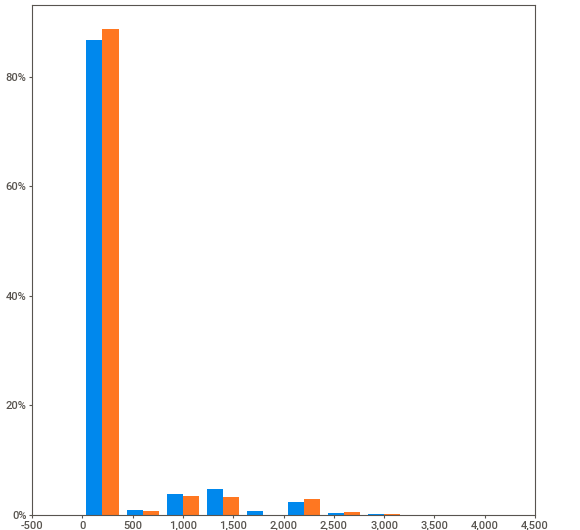
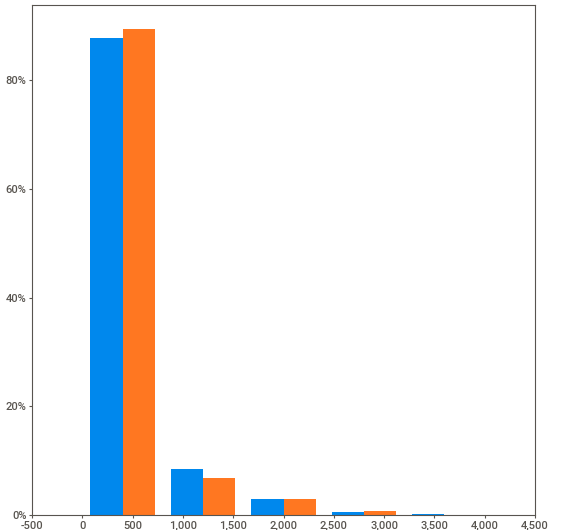
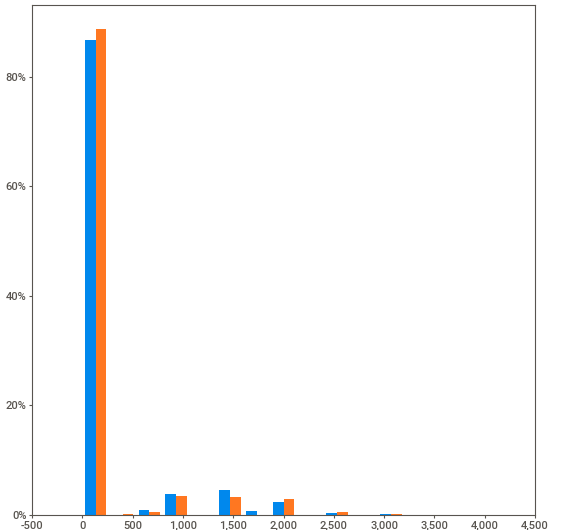
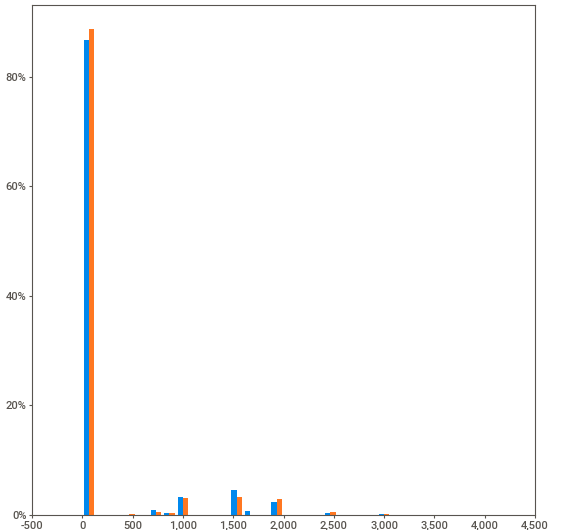
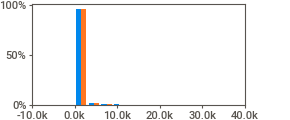
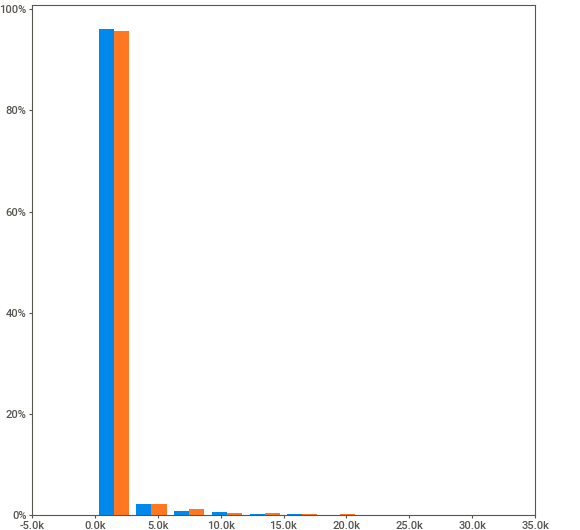
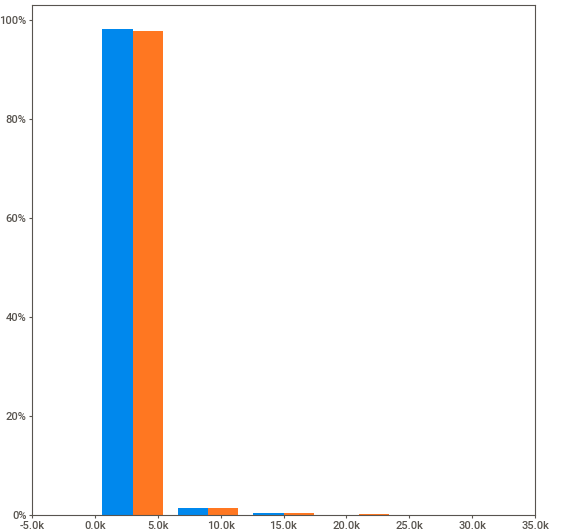
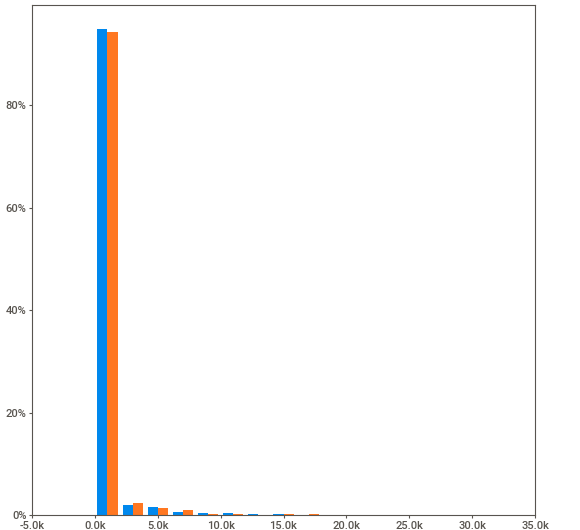
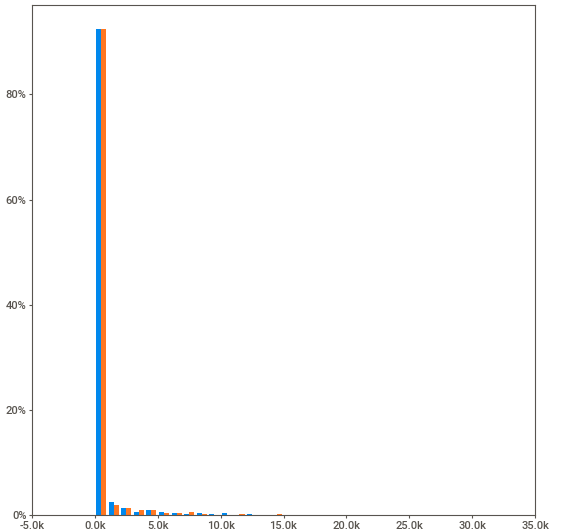
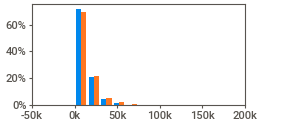
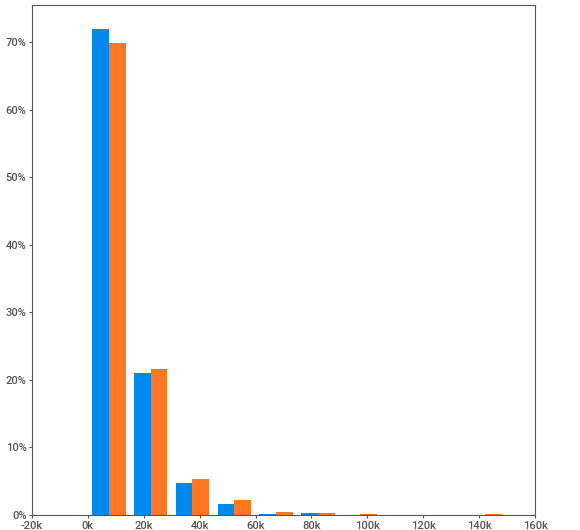
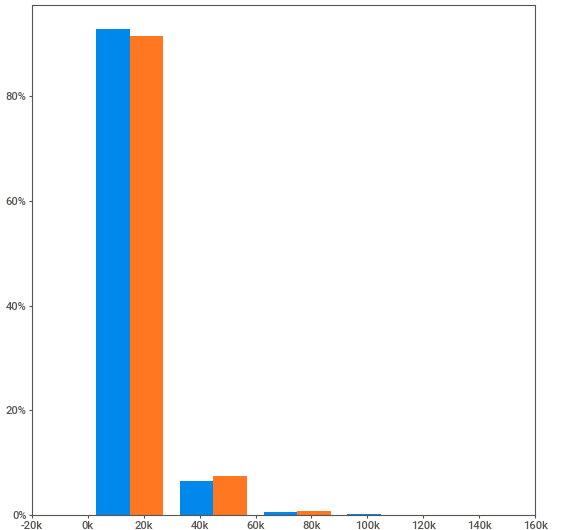
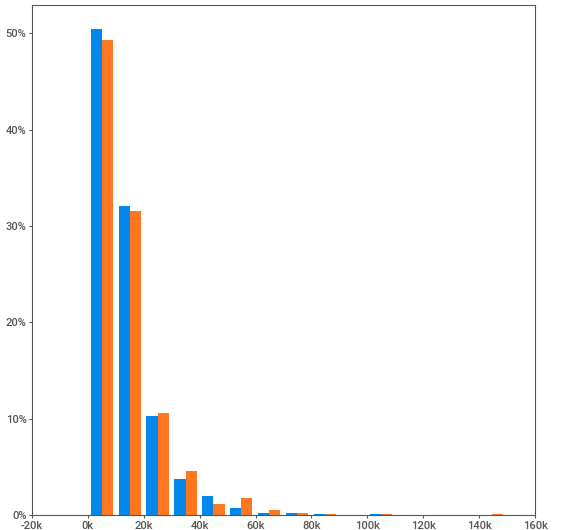
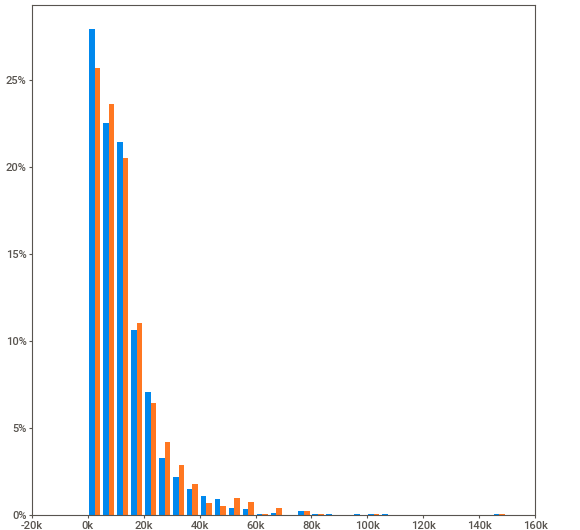
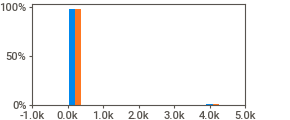
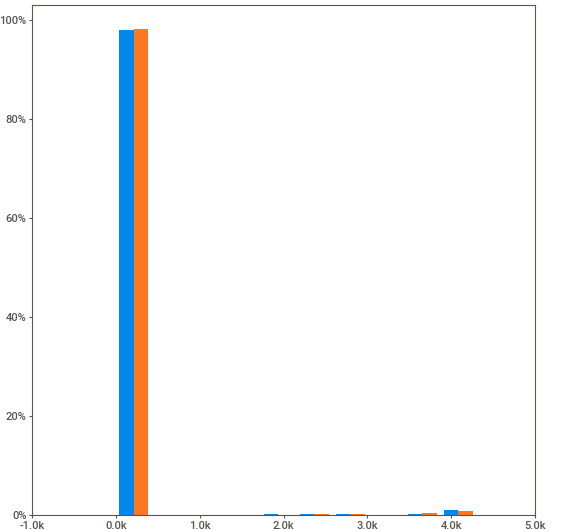
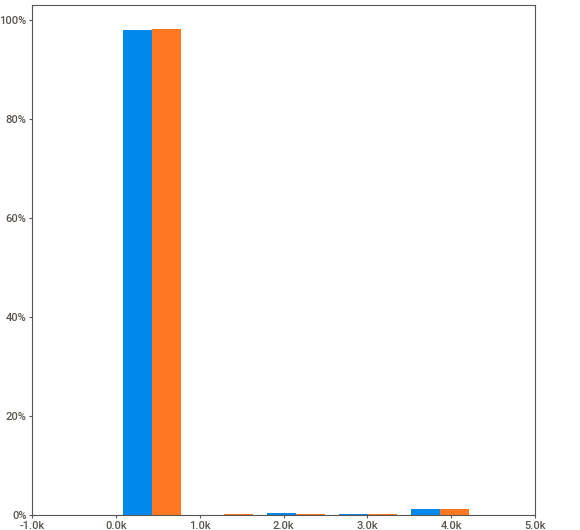
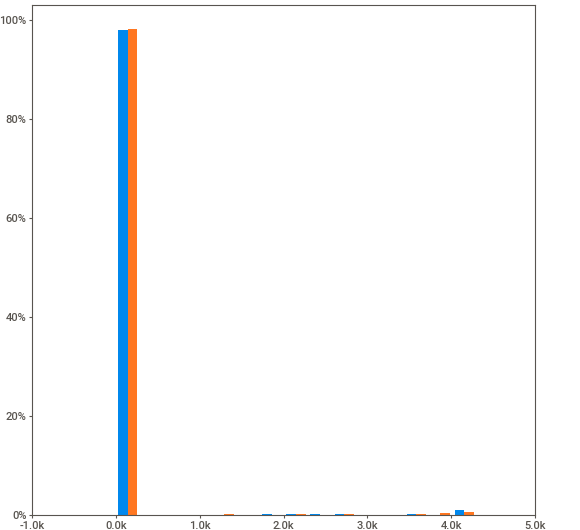
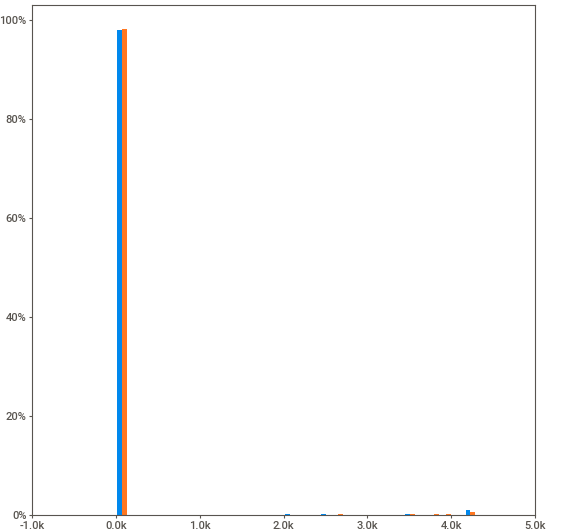
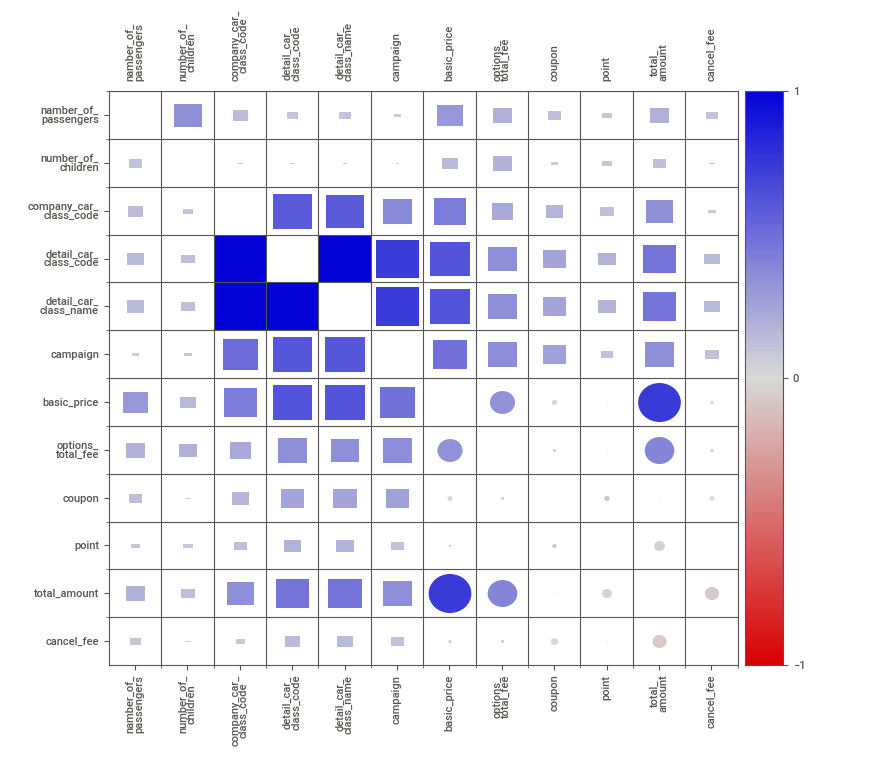
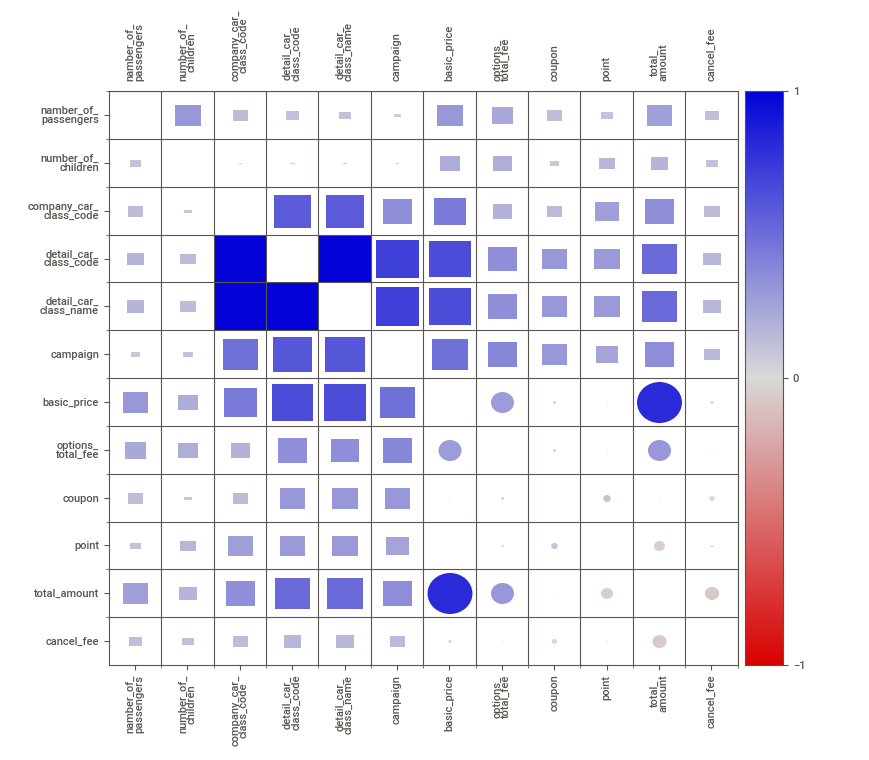

In [12]:
comparison_report.show_notebook()

#### Модель як є (без змін)

In [13]:
import numpy as np  
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from sklearn.model_selection import GridSearchCV,cross_val_score  
from sklearn import  metrics  
import matplotlib.pylab as plt

#### Позбудемось колонок з якими не працює алгоритм в заданому вигляді:

In [14]:
invalid_columns = ['request_date_time', 'flight_number', 'pickup_date_time', 'return_date_time',
                   'company_car_class_code', 'detail_car_class_code', 'detail_car_class_name',
                   'campaign', 'options']

In [15]:
X = X.drop(invalid_columns, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [16]:
xgb0 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                     gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27) 
xgb0.fit(X_train, y_train, eval_metric='auc') 
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = xgb0.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.18493723849372384
Recall = 0.18493723849372384
Accuracy = 0.18493723849372384


<h3 style='text-align:center; color:#FF8C00; margin-bottom:40px;'>Точність передбачення 18,49%</h3>

# Додамо декілька фіч

####  Додамо святкові дні

In [17]:
holidays = pd.read_csv('holidays_Japan.csv')

In [18]:
holidays['date'] = pd.to_datetime(holidays['day']).dt.date

In [19]:
df['date'] = pd.to_datetime(df.pickup_date_time).dt.date

In [20]:
holidays = holidays[['Japan', 'date']].rename(columns={'Japan':'holiday'})
df = df.merge(holidays,  how='inner', on=['date'])

####  Додамо дані про погоду

In [21]:
weather = pd.read_csv('weather_Hokkaido.csv')

In [22]:
weather['date'] = pd.to_datetime(weather.date).dt.date

In [23]:
weather = weather[['date', 'high_temp', 'low_temp', 'rain_probability']]

In [24]:
df['high_temp'] = None
df['low_temp'] = None
df['rain_probability'] = None
for i in df.index:
    try:
        idx = weather[weather.date == df['date'][i]].index[0]
        df['high_temp'][i] = weather['high_temp'][idx]
        df['low_temp'][i] = weather['low_temp'][idx]
        df['rain_probability'][i] = weather['rain_probability'][idx]
    except:
        pass

P.S. 
> через megre не вдалось отримати задуманого результату, в процесі пракитики сподіваюсь знайду спосіб щоб вирішити аналогчну проблему

#### Період між замовленням та датою поїзки на авто в годинах:

In [25]:
df['from_request_to_pickup'] = (pd.to_datetime(df.pickup_date_time) - pd.to_datetime(df.request_date_time)).astype('timedelta64[h]').astype('int')

#### Період між датою поїзки та датою повернення авто в годинах:

In [26]:
df['rental_duration'] = (pd.to_datetime(df.return_date_time) - pd.to_datetime(df.pickup_date_time)).astype('timedelta64[h]').astype('int')

#### Кількість дорослих пасажирів:

In [27]:
df['number_of_adult'] = df.namber_of_passengers - df.number_of_children

#### Вартість на одного дорослого пасажира:

In [28]:
df['amount_per_person'] = df.total_amount/df.number_of_adult

#### Вартість за годину аренди загальна:

In [29]:
df['cost_per_hour_total'] = df.total_amount/df.rental_duration

#### Вартість на одного дорослого за годину аренди:

In [30]:
df['price_per_adult_per_hour'] = df.amount_per_person/df.rental_duration

In [31]:
df.shape

(3983, 29)

In [32]:
X = df.drop('booking_status', axis=1)
y = df['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [34]:
invalid_columns = ['booking_status', 'request_date_time','flight_number', 'pickup_date_time', 'return_date_time',
                   'company_car_class_code', 'detail_car_class_code', 'detail_car_class_name',
                   'campaign', 'options', 'date', 'high_temp', 'low_temp', 'rain_probability']
X = df.drop(invalid_columns, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [35]:
xgb1 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                     gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27) 
xgb1.fit(X_train, y_train, eval_metric='auc') 
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = xgb1.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.2100418410041841
Recall = 0.2100418410041841
Accuracy = 0.2100418410041841


<h3 style='text-align:center; color:#FF8C00; margin-bottom:40px;'>
    Точність передбачення, дещо зросла = 21%</h3>

## Додамо змінні часу похідні від `request_date_time`, `pickup_date_time` та `return_date_time`

In [36]:
def create_date_features(df, columns, label=None):
    """
    Creates time series features from datetime index
    """
    
    df[f'{label}_date'] = pd.to_datetime(df[columns])
    df[f'{label}_dayofweek'] = df[f'{label}_date'].dt.dayofweek
    df[f'{label}_quarter'] = df[f'{label}_date'].dt.quarter
    df[f'{label}_month'] = df[f'{label}_date'].dt.month
    df[f'{label}_year'] = df[f'{label}_date'].dt.year
    df[f'{label}_dayofyear'] = df[f'{label}_date'].dt.dayofyear
    df[f'{label}_dayofmonth'] = df[f'{label}_date'].dt.day
    df[f'{label}_weekofyear'] = df[f'{label}_date'].dt.weekofyear
    
    df.drop(f'{label}_date', inplace=True, axis=1)
    df.drop(columns, inplace=True, axis=1)
    return df

In [37]:
df = create_date_features(df, 'request_date_time', label='request')
df = create_date_features(df, 'pickup_date_time', label='pickup')
df = create_date_features(df, 'return_date_time', label='return')

In [38]:
X = df.drop('booking_status', axis=1)
invalid_columns = ['flight_number', 'company_car_class_code', 'detail_car_class_code',
                   'detail_car_class_name', 'campaign', 'options', 'date', 'high_temp',
                   'low_temp', 'rain_probability']

X = df.drop(invalid_columns, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [39]:
xgb2 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                     gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27) 
xgb2.fit(X_train, y_train, eval_metric='auc') 
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = xgb2.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))

Precision = 0.19330543933054392
Recall = 0.19330543933054392
Accuracy = 0.19330543933054392


<h3 style='text-align:center; color:#FF8C00; margin-bottom:40px;'>точність передбачення НИЖЧА майже на 2% = 19,33%</h3>

# Підготуємо до бінаризації категорійні змінні:
#### company_car_class_code:

In [40]:
_company_car_class_code = {'【ナビ・ETC付】コンパクトクラス': 'Compact Class',
 '【ナビETC付】7～8人乗りワンボックス': 'One Box',
 '【ナビ・ETC付】軽乗用車クラス': 'Light Passenger Class',
 '【新車・ナビ・ETC付】SPクラス': 'SP class',
 '【ナビ・ETC付】ミドルクラス': 'Middle Class',
 '【新車・ナビ・ＥＴＣ付】ＧＰ５クラス': 'GP5 class',
 'ＨＶ-2': 'HV-2',
 '【ナビ・ETC付】HVクラス': 'HV Class',
 '【ＥＴＣ・ナビ付】禁煙コンパクト': 'Non-smoking Compact',
 '【ナビ・ETC付】G７クラス': 'G7 Class',
 'Fクラス免込（禁・スタッド・4WD）': 'Free F-Class',
 'Sクラス免込（禁煙・スタッド・4WD）': 'Free S-Class',
 '曜日別ＣＰ': 'CP',
 'SPクラス免込（禁煙・スタッド・4WD）': 'Free SP class'}
df['company_car_class_code'] = df.company_car_class_code.apply(lambda string: _company_car_class_code[string])

#### detail_car_class_code:

In [41]:
_detail_car_class_code = {'Sクラス（スタッドレス・4WD・喫煙可）': 'S-Class s4s',
 'Fクラス（禁煙・スタッドレス・4WD）': 'F-Class ns4)',
 'Sクラス（喫煙）': 'S-Class s)',
 'Kクラス（禁煙・スタッドレス・4WD）': 'K-Class ns4)',
 'Sクラス（禁煙・スタッドレス・4WD）': 'S-Class ns4',
 'SPクラス（禁煙・スタッドレス・4WD）': 'SP Class ns4)',
 'Gクラス（禁煙・スタッドレス・4WD）': 'G-Class ns4',
 'Fクラス（禁煙）': 'Class F n',
 'Gクラス（禁煙）': 'G-Class n',
 '【楽天スーパーセール】SPクラス': 'SP Class',
 'Kクラス（禁煙）': 'Class K n',
 'SPクラスキャンペーン（禁煙)': 'SP Class Campaign n',
 'Sクラス（禁煙）': 'S-Class n',
 'SPクラス（禁煙）': 'SP class n',
 'Sクラス免責安心込み（禁煙）': 'Includes S-Class wn',
 'Kクラス免責安心込み（禁煙）': 'Includes K-Class wpn',
 'Fクラス免責安心込み（禁煙)': 'F-Class dpn',
 'SPクラス免責安心込み（禁煙)': 'SP class dpn',
 'ＧＰクラス禁煙５人乗り': 'GP class n5p',
 'Sクラス免責安心込み（喫煙）': 'S-Class wis',
 'Gクラス免責安心込み（喫煙)': 'G-Class wis',
 'ＳＰキャリア（ナビ、ＥＴＣ、4ＷＤ、キャリア付）': 'SP Carrier we4c',
 'Fクラス（喫煙）': 'Class F (smoking)',
 '楽天スーパーセール専用Ｓ': 'Exclusive S rss',
 'ＨＶ-2新横浜': 'HV-2 sy',
 'HVクラス（禁煙）': 'HV class n',
 '【楽天スーパーセール】Gクラス': 'G-Class rss',
 '【ＥＴＣ・ナビ付】禁煙コンパクト': 'Non-smoking Compact wen',
 'Ｇ７クラス': 'G7 class',
 'Fクラス免責込（禁煙・スタッド・4WD）': 'F-Class dins4',
 'Sクラス免責込（禁煙・スタッド・4WD）': 'S-Class dins4',
 'Sクラスフルパッケージ（禁煙）': 'S-Class fpn',
 'SPクラスフルパッケージ（禁煙)': 'SP Class fpn',
 '日曜日出発ＣＰコンパクト': 'Sunday dcc',
 'SPクラス免責込（禁煙・スタッド・4WD）': 'SP class dins4',
 '【楽天スーパーセール】Fクラス': 'F-Class rss',
 '免責補償込ＨＶクラス': 'HV class wdc',
 'Gクラス免責安心込み（禁煙)': 'G-Class din'}
df['detail_car_class_code'] = df.detail_car_class_code.apply(lambda string: _detail_car_class_code[string])

In [42]:
_detail_car_class_name = {'Sクラス（スタッドレス・4WD・喫煙可）': 'S-Class s4s',
 'Fクラス（禁煙・スタッドレス・4WD）': 'F-Class ns4)',
 'Sクラス（喫煙）': 'S-Class s)',
 'Kクラス（禁煙・スタッドレス・4WD）': 'K-Class ns4)',
 'Sクラス（禁煙・スタッドレス・4WD）': 'S-Class ns4',
 'SPクラス（禁煙・スタッドレス・4WD）': 'SP Class ns4)',
 'Gクラス（禁煙・スタッドレス・4WD）': 'G-Class ns4',
 'Fクラス（禁煙）': 'Class F n',
 'Gクラス（禁煙）': 'G-Class n',
 '【楽天スーパーセール】SPクラス': 'SP Class',
 'Kクラス（禁煙）': 'Class K n',
 'SPクラスキャンペーン（禁煙）': 'SP Class cn',
 'Sクラス（禁煙）': 'S-Class n',
 'SPクラス（禁煙）': 'SP class n',
 'Sクラス免責安心込み（禁煙）': 'Includes S-Class wn',
 'Kクラス免責安心込み（禁煙）': 'Includes K-Class wpn',
 'Fクラス免責安心込み（禁煙）': 'Class F dwin',
 'SPクラス免責安心込み（禁煙）': 'SP class dpmin',
 'キューブ他': 'Cube and others',
 'Sクラス免責安心込み（喫煙）': 'S-Class wis',
 'Gクラス免責安心込み（喫煙）': 'G-Class wis',
 'ＳＰキャリア（ナビ、ＥＴＣ、4ＷＤ、キャリア付）': 'SP Carrier we4c',
 'Fクラス（喫煙）': 'Class F s',
 '楽天スーパーセルＳクラス': 'Rakuten Supercell S-Class',
 '新横浜プリウスクラス': 'Shin-Yokohama Prius Class',
 'HVクラス（禁煙）': 'HV class n',
 '【楽天スーパーセール】Gクラス': 'G-Class rss',
 'スイフト、ヴィッツ、デミオなど': 'Swift vd_ect',
 'プレマシー、ストリーム他': 'Premacy sao',
 'Fクラス免責込（禁煙・スタッド・4WD）': 'F-Class dins4',
 'Sクラス免込（禁煙・4WD・スタッド）': 'Free S-Class n4s',
 'Sクラスフルパッケージ（禁煙）': 'S-Class fpn',
 'SPクラスフルパッケージ（禁煙)': 'SP Class fpn',
 '日曜日出発ＣＰコンパクト': 'Sunday dcc',
 'SPクラス免込（禁煙・4WD・スタッド）': 'SP class fn4s',
 '【楽天スーパーセール】Fクラス': 'F-Class rss',
 '免責補償込ＨＶクラス': 'HV class wdc',
 'Gクラス免責安心込み（禁煙）': 'G-Class win',
 'SPクラスキャンペーン（禁煙)': 'SP Class Campaign n',
 'Fクラス免責安心込み（禁煙)': 'F-Class dpn',
 'SPクラス免責安心込み（禁煙)': 'SP class dpn',
 'ＧＰクラス禁煙５人乗り': 'GP class n5p',
 'Gクラス免責安心込み（喫煙)': 'G-Class wis',
 '楽天スーパーセール専用Ｓ': 'Exclusive S rss',
 'ＨＶ-2新横浜': 'HV-2 sy',
 '【ＥＴＣ・ナビ付】禁煙コンパクト': 'Non-smoking Compact wen',
 'Ｇ７クラス': 'G7 class',
 'Sクラス免責込（禁煙・スタッド・4WD）': 'S-Class dins4',
 'SPクラス免責込（禁煙・スタッド・4WD）': 'SP class dins4',
 'Gクラス免責安心込み（禁煙)': 'G-Class din'}
df['detail_car_class_name'] = df.detail_car_class_name.apply(lambda string: _detail_car_class_name[string])

# вважаю, що дана колонка `detail_car_class_name` майже відповідає колонці `detail_car_class_code`

In [43]:
df.drop('detail_car_class_name', inplace=True, axis=1)

#### campaign:

In [44]:
code_campaign={}
for num, i in enumerate(data.campaign.unique()):
    code_campaign[i] = f'campaign_{num}'
code_campaign
df['campaign'] = df.campaign.apply(lambda string: code_campaign[string])

#### options:

In [45]:
options = [' 免責補償制度 x 1', '喫煙車 x 1', ' 免責補償フル込プラン(フル補償) x 1', ' ＥＴＣ x 1', ' 手動運転装置(足の不自由な方用) x 1', ' 喫煙車 x 1', ' ジュニアシート x 1', 'カーナビ x 1', ' 免責補償プラス(免責補償加入必須・NOC免除) x 1', '禁煙車 x 1', 'チャイルドシート x 2', ' 免責補償フル(免責補償・プラス加入必須、お客様負担ゼロ) x 1', ' スタッドレスキャンペーン x 1', ' 4WD x 1', 'ＥＴＣ x 1', ' ETCカード x 1', ' ジュニアシート x 2', 'カーナビキャンペーン用 x 1', ' 免責保証込プラン x 1', 'チャイルドシート x 1', ' 禁煙車 x 1', ' カーナビキャンペーン用 x 1', ' 免責補償プラス込プラン(NOC免除) x 1', '免責補償制度 x 1']
option_translate_ = ['Collision exemption system x 1', 'Smoking car x 1', 'Full exemption compensation plan (full compensation) x 1', 'ETC x 1', 'Manual driving device (for disabled people) x 1', 'Smoking car x 1', 'Junior seat x 1', 'Car navigation system x 1', 'Collision exemption plus (necessary to subscribe to exemption compensation/NOC exemption) x 1', 'Non-smoking car x 1', 'Child seat x 2', ' Full disclaimer compensation (disclaimer compensation plus subscription required, no customer burden) x 1', ' Studless campaign x 1', ' 4WD x 1', 'ETC x 1', 'ETC card x 1', ' Junior seat x 2', 'Car navigation campaign x 1', 'Disclaimer plan x 1', 'Child seat x 1', 'Non-smoking car x 1', 'Car navigation campaign x 1', 'Plan with exemption compensation plus (NOC Exemption) x 1', 'Disclaimer Compensation System x 1']
option_translate_dictionary = dict(zip(options, option_translate_))

In [46]:
def list_translate_option(lst):
    for j,i in enumerate(lst):
        lst[j] = option_translate_dictionary[i]
    return lst

df.options = df.options.apply(lambda string:','.join(list_translate_option(string.split(','))))

In [47]:
def opt_counter(string):
    lst = []
    option_translate_ = ['Collision exemption system x 1', 'Smoking car x 1', 'Full exemption compensation plan (full compensation) x 1', 'ETC x 1', 'Manual driving device (for disabled people) x 1', 'Smoking car x 1', 'Junior seat x 1', 'Car navigation system x 1', 'Collision exemption plus (necessary to subscribe to exemption compensation/NOC exemption) x 1', 'Non-smoking car x 1', 'Child seat x 2', ' Full disclaimer compensation (disclaimer compensation plus subscription required, no customer burden) x 1', ' Studless campaign x 1', ' 4WD x 1', 'ETC x 1', 'ETC card x 1', ' Junior seat x 2', 'Car navigation campaign x 1', 'Disclaimer plan x 1', 'Child seat x 1', 'Non-smoking car x 1', 'Car navigation campaign x 1', 'Plan with exemption compensation plus (NOC Exemption) x 1', 'Disclaimer Compensation System x 1']
    for i in option_translate_:
        lst.append(string.split(',').count(i))
    return lst

df.options = df.options.apply(opt_counter)

In [48]:
options_feature = pd.DataFrame(columns=option_translate_, index=data.index)
for i in options_feature.index:
    options_feature.loc[i] = df.options[i]

In [49]:
df = df.join(options_feature)

In [50]:
df.drop('options', inplace=True, axis=1)

In [56]:
X = df.drop('booking_status', axis=1)
y = df['booking_status']
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#### в найменуванні змінних є повторення:

In [59]:
from collections import Counter
duplicate = [k for k,v in Counter(X.columns).items() if v>1]

In [61]:
X= X.drop(duplicate, axis=1)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
xgb2 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                     gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27) 
xgb2.fit(X_train, y_train, eval_metric='auc') 
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = xgb2.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision_Racuten = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall_Racuten = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy_Racuten = {}".format(accuracy_score(y_test, best_preds)))

Precision_Racuten = 0.20251046025104602
Recall_Racuten = 0.20251046025104602
Accuracy_Racuten = 0.20251046025104602


<h3 style='text-align:center; color:#FF8C00; margin-bottom:40px;'>точність передбачення дещо зросла = 20,25%</h3>

In [66]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=None)
PCA_fit = pca.fit(X)
PCA_transform = pca.transform(X)
PCA_explained = pca.explained_variance_ratio_

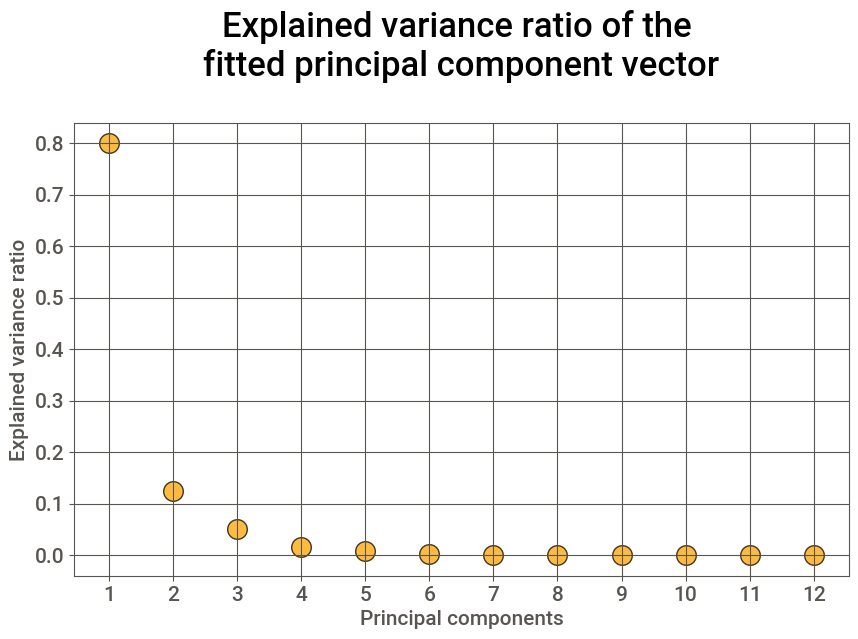

In [68]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.scatter(x=[i+1 for i in range(len(PCA_explained))][:12],
            y=PCA_explained[:12],
           s=200, alpha=0.75,c='orange',edgecolor='k')
plt.grid(True)
plt.title("Explained variance ratio of the \nfitted principal component vector\n",fontsize=25)
plt.xlabel("Principal components",fontsize=15)
plt.xticks([i+1 for i in range(len(PCA_explained))][:12],fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Explained variance ratio",fontsize=15)
plt.show()

In [70]:
sum(PCA_explained[:5]*100)

99.72231904288795

Відберем перші 5-ть головних компонент

In [72]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(PCA_transform[:, 0:5], y, test_size=0.3)

In [73]:
import pandas as pd  
import numpy as np  
import xgboost as xgb
from xgboost.sklearn import XGBClassifier  
from sklearn.model_selection import GridSearchCV,cross_val_score  
from sklearn import  metrics  
import matplotlib.pylab as plt

In [74]:
xgb4 = XGBClassifier(learning_rate=0.1,n_estimators=1000,max_depth=9,min_child_weight=1,
                     gamma=0,subsample=0.8,colsample_bytree=0.8,objective= 'binary:logistic',
                     nthread=4,scale_pos_weight=1,seed=27) 
xgb4.fit(X_train, y_train, eval_metric='auc') 
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
preds = xgb4.predict(X_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision_Racuten = {}".format(precision_score(y_test, best_preds, average='micro', zero_division=0)))
print("Recall_Racuten = {}".format(recall_score(y_test, best_preds, average='micro')))
print("Accuracy_Racuten = {}".format(accuracy_score(y_test, best_preds)))

Precision_Racuten = 0.18744769874476988
Recall_Racuten = 0.18744769874476988
Accuracy_Racuten = 0.18744769874476988


<h3 style='text-align:center; color:#FF8C00; margin-bottom:40px;'>Рівень точності знизився майже до вихідного значення = 18,75%</h3>

Вважаю що потрібно сгрупувати дані за показником `request_date_time` або `pickup_date_time` і провести аналогічні розрахунки так як прогнозування щоденної кількості броньованих автомобілів треба проводити за часом (період січень 2019 року – лютий 2019 року) без скасування:`booking_status`